In [32]:
import pandas as pd
import chardet
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb


In [41]:
warnings.filterwarnings('ignore')

df = pd.read_excel('fs_test_data.xlsx')
df


,Date,price,promotion,region,type,revenue
0,2004-02-22,25.360000,0,reg1,tblre,6907.0
1,2004-02-29,25.490000,0,reg1,tblre,4350.0
2,2004-03-07,25.190000,0,reg1,tblre,3833.0
3,2004-03-14,25.700000,0,reg1,tblre,3746.0
4,2004-03-21,25.710000,0,reg1,tblre,4302.0
...,...,...,...,...,...,...
3547,2008-04-20,66.915054,0,reg4,vinta,NaN
3548,2008-04-27,51.401790,0,reg4,vinta,NaN
3549,2008-05-04,37.639410,0,reg4,vinta,NaN
3550,2008-05-11,47.990068,0,reg4,vinta,NaN


In [42]:
df.describe()

,Date,price,promotion,revenue
count,3552,3552.000000,3552.000000,2720.000000
mean,2006-04-05 12:00:00,40.773254,0.024493,3551.444118
min,2004-02-22 00:00:00,10.190217,0.000000,144.000000
25%,2005-03-13 00:00:00,27.180000,0.000000,825.750000
50%,2006-04-05 12:00:00,27.700000,0.000000,1680.000000
75%,2007-04-29 00:00:00,51.810833,0.000000,4648.000000
max,2008-05-18 00:00:00,156.194117,1.000000,21911.000000
std,NaN,28.366466,0.154596,4072.064694


In [43]:
def prepare_date(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['week'] = df['Date'].dt.isocalendar().week
    df = df.set_index('Date')
    return df


def prepare_categorical_data(df):
    df_encoded = df.copy()
    encoder = OneHotEncoder(sparse_output=False, drop=None, dtype=int)
    
    categorical_data = df[['type', 'region']]
    encoded_array = encoder.fit_transform(categorical_data)
    feature_names = encoder.get_feature_names_out(['type', 'region'])
    
    encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=df.index)
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
    df_encoded = df_encoded.drop(columns=['type', 'region'])
    
    return df_encoded, encoder

def fill_revenue_nan(df):
    df_filled = df.copy()
    df_filled['revenue'] = df_filled['revenue'].interpolate(method='time')
    return df_filled

#вроде не нужно скейлить ничего в timeseries, но для некоторых моделей нужно только признаки
def scale_price(df):
    num_cols = ['price']
    scaler = MinMaxScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    return df


def prepare_data(df, target_col, test_start, test_end):
    feature_columns = [col for col in df.columns if col != target_col]
    
    train_mask = (df.index < test_start)
    test_mask = (df.index >= test_start) & (df.index <= test_end)
    
    x_train = df.loc[train_mask, feature_columns]
    y_train = df.loc[train_mask, target_col]
    
    x_test = df.loc[test_mask, feature_columns]
    y_test = df.loc[test_mask, target_col]
        
    return x_train, x_test, y_train, y_test, feature_columns
    
def full_prep(df):
    df = prepare_date(df)
    df, onehot_encoder = prepare_categorical_data(df)
    df = fill_revenue_nan(df)
    df = scale_price(df)
    x_train, x_test, y_train, y_test, feature_columns = prepare_data(df, 'revenue',
    test_start='2006-05-28',
    test_end='2007-05-20')
    return df, x_train, x_test, y_train, y_test, feature_columns




In [44]:
df, x_train, x_test, y_train, y_test, feature_columns = full_prep(df)

In [8]:
df

,price,promotion,revenue,year,month,week,type_tblre,type_tblwt,type_value,type_vinta,region_reg1,region_reg2,region_reg3,region_reg4
Date,,,,,,,,,,,,,,
2004-02-22,0.103900,0,6907.0,2004,2,8,1,0,0,0,1,0,0,0
2004-02-29,0.104790,0,4350.0,2004,2,9,1,0,0,0,1,0,0,0
2004-03-07,0.102735,0,3833.0,2004,3,10,1,0,0,0,1,0,0,0
2004-03-14,0.106229,0,3746.0,2004,3,11,1,0,0,0,1,0,0,0
2004-03-21,0.106297,0,4302.0,2004,3,12,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-04-20,0.388516,0,15844.0,2008,4,16,0,0,0,1,0,0,0,1
2008-04-27,0.282264,0,15844.0,2008,4,17,0,0,0,1,0,0,0,1
2008-05-04,0.188003,0,15844.0,2008,5,18,0,0,0,1,0,0,0,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3552 entries, 2004-02-22 to 2008-05-18
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        3552 non-null   float64
 1   promotion    3552 non-null   int64  
 2   revenue      3552 non-null   float64
 3   year         3552 non-null   int32  
 4   month        3552 non-null   int32  
 5   week         3552 non-null   UInt32 
 6   type_tblre   3552 non-null   int64  
 7   type_tblwt   3552 non-null   int64  
 8   type_value   3552 non-null   int64  
 9   type_vinta   3552 non-null   int64  
 10  region_reg1  3552 non-null   int64  
 11  region_reg2  3552 non-null   int64  
 12  region_reg3  3552 non-null   int64  
 13  region_reg4  3552 non-null   int64  
dtypes: UInt32(1), float64(2), int32(2), int64(9)
memory usage: 378.1 KB


Random Forest MAPE: 0.1580 (15.80%)
Random Forest RMSE: 1804


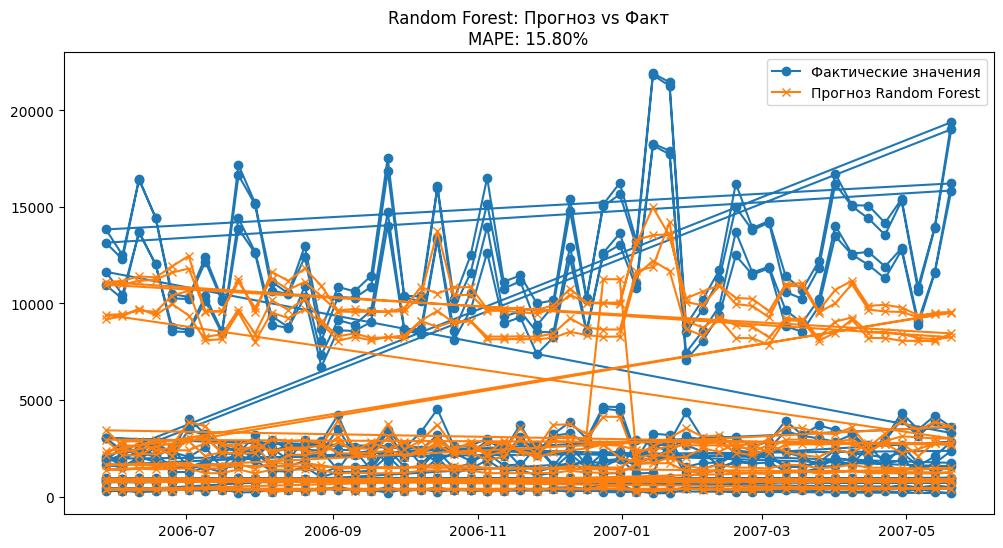

In [11]:
def train_random_forest(x_train, x_test, y_train, y_test, n_estimators=100):
    rf_model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=10,
        min_samples_split=5,
        n_jobs=-1 
    )
    
    rf_model.fit(x_train, y_train)
    
    y_pred = rf_model.predict(x_test)
    
    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"Random Forest MAPE: {mape:.4f} ({mape*100:.2f}%)")
    print(f"Random Forest RMSE: {rmse:.0f}")
    
    return rf_model, y_pred, mape


rf_model, y_pred, rf_mape = train_random_forest(x_train, x_test, y_train, y_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Прогноз Random Forest', marker='x')
plt.title(f'Random Forest: Прогноз vs Факт\nMAPE: {rf_mape*100:.2f}%')
plt.legend()
plt.show()

In [28]:
def time_series_grid_search(X, y, param_grid, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    rf = RandomForestRegressor(n_jobs=-1)
    
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=tscv,
        scoring=mape_scorer,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X, y)
    
    print("лучшие параметры:", grid_search.best_params_)
    print("лучший MAPE:", -grid_search.best_score_)
    
    return grid_search.best_estimator_, grid_search.best_params_


feature_columns = [col for col in df.columns if col != 'revenue']
x = df[feature_columns]
y = df['revenue']

train_mask = df.index < '2006-05-28'
x_train_val = x_train
y_train_val = y_train

print(f"данные для Grid Search: {x_train_val.shape}")


param_grid_extended = {
        'n_estimators': [200, 300, 400, 500],  
        'max_depth': [10, 15, 20, None],      
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7],
        'bootstrap': [True],
        'max_samples': [0.7, 0.8, 0.9, None]   
    }

best_model, best_params = time_series_grid_search(
    x_train_val, y_train_val, param_grid_extended, n_splits=5
)

Данные для Grid Search: (1888, 13)
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Лучшие параметры: {'bootstrap': False, 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Лучший MAPE: 2.4819457933107634


Random Forest MAPE: 0.1482 (14.82%)
Random Forest RMSE: 1719


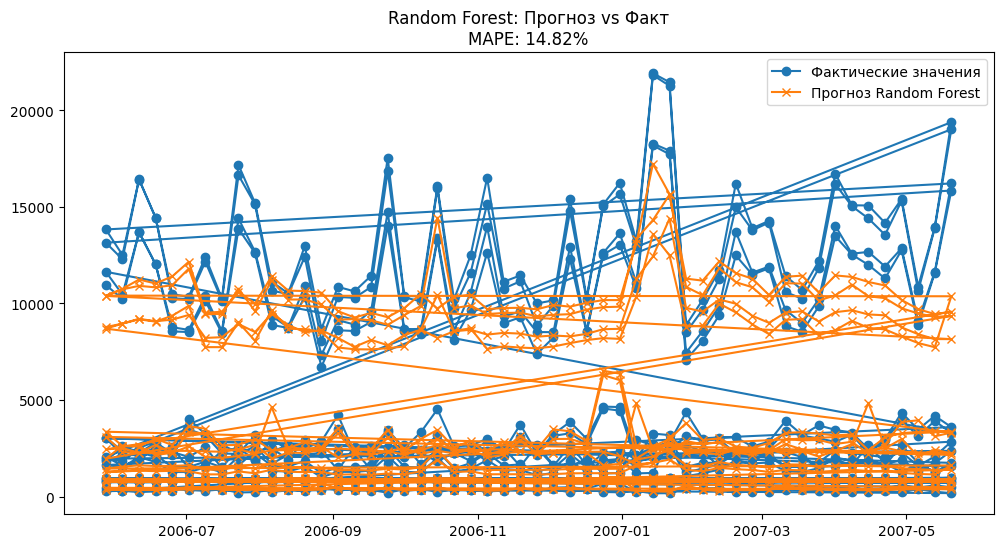

In [34]:

y_pred = best_model.predict(x_test)
    
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
print(f"Random Forest MAPE: {mape:.4f} ({mape*100:.2f}%)")
print(f"Random Forest RMSE: {rmse:.0f}")
    

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Прогноз Random Forest', marker='x')
plt.title(f'Random Forest: Прогноз vs Факт\nMAPE: {mape*100:.2f}%')
plt.legend()
plt.show()

In [45]:
def random_forest_forecast(df, target_col, model, final_date='2007-05-20', forecast_steps=26):

    train_data = df[df.index <= final_date].copy()
    feature_columns = [col for col in train_data.columns if col != target_col]
    
    future_dates = pd.date_range(
        start=train_data.index[-1] + pd.Timedelta(weeks=1),
        periods=forecast_steps,
        freq='W'
    )
    
    future_forecast = []
    lower_bounds = []
    upper_bounds = []
    
    current_data = train_data.copy()
    
    for i in range(forecast_steps):
        last_row = current_data.iloc[[-1]][feature_columns]
        
        prediction = model.predict(last_row)[0]
        future_forecast.append(prediction)
        
     
        uncertainty = prediction * 0.1 
        lower_bounds.append(prediction - uncertainty)
        upper_bounds.append(prediction + uncertainty)
        
        new_date = current_data.index[-1] + pd.Timedelta(weeks=1)
        new_row = pd.DataFrame(index=[new_date])
        new_row[target_col] = prediction
        
        for col in feature_columns:
            new_row[col] = last_row[col].iloc[0]
        
        current_data = pd.concat([current_data, new_row])
    
    forecast_df = pd.DataFrame({
        'point_forecast': future_forecast,
        'lower_95': lower_bounds,
        'upper_95': upper_bounds
    }, index=future_dates)
    
    return forecast_df


rf_forecast_26 = simple_random_forest_forecast(
    df,
    'revenue',
    best_model, 
    final_date='2007-05-20',
    forecast_steps=26
)

print("прогноз на 26 недель:")
print(rf_forecast_26.round(0))

прогноз на 26 недель:
            point_forecast  lower_95  upper_95
2007-05-27           809.0     728.0     890.0
2007-06-03           809.0     728.0     890.0
2007-06-10           809.0     728.0     890.0
2007-06-17           809.0     728.0     890.0
2007-06-24           809.0     728.0     890.0
2007-07-01           809.0     728.0     890.0
2007-07-08           809.0     728.0     890.0
2007-07-15           809.0     728.0     890.0
2007-07-22           809.0     728.0     890.0
2007-07-29           809.0     728.0     890.0
2007-08-05           809.0     728.0     890.0
2007-08-12           809.0     728.0     890.0
2007-08-19           809.0     728.0     890.0
2007-08-26           809.0     728.0     890.0
2007-09-02           809.0     728.0     890.0
2007-09-09           809.0     728.0     890.0
2007-09-16           809.0     728.0     890.0
2007-09-23           809.0     728.0     890.0
2007-09-30           809.0     728.0     890.0
2007-10-07           809.0     728.0  

In [29]:
def optimize_xgboost(x_train, y_train, n_iter):

    param_distributions = {
        'n_estimators': [100, 200, 300, 400, 500],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1, 5],
        'reg_lambda': [0, 0.1, 0.5, 1, 5],
        'min_child_weight': [1, 3, 5, 7]
    }
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        verbosity=0
    )
    
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    

    search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_distributions,
        n_iter=n_iter,  
        cv=tscv,
        scoring=mape_scorer,
        n_jobs=-1,
        verbose=1
    )
  
    search.fit(x_train, y_train)
    
    print("Лучшие параметры:", search.best_params_)
    print("Лучший MAPE:", -search.best_score_)
    
    return search.best_estimator_, search.best_params_

optimized_xgb, best_xgb_params = optimize_xgboost(
    x_train, y_train, n_iter=400
)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Лучшие параметры: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Лучший MAPE: 1.8969055327613096


XGB MAPE: 0.2299 (22.99%)
XGB RMSE: 1982


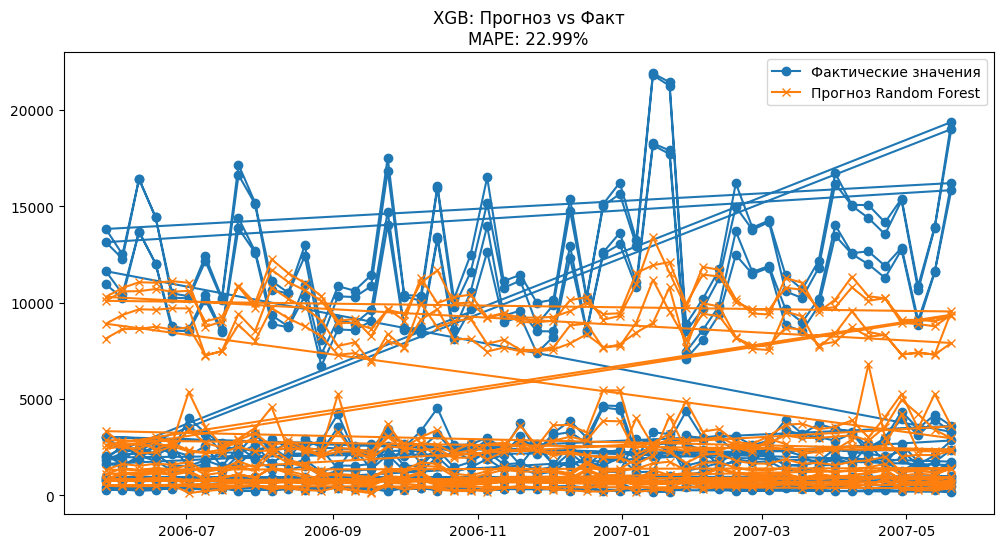

In [30]:
y_pred = optimized_xgb.predict(x_test)
    
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
print(f"XGB MAPE: {mape:.4f} ({mape*100:.2f}%)")
print(f"XGB RMSE: {rmse:.0f}")
    

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Фактические значения', marker='o')
plt.plot(y_test.index, y_pred, label='Прогноз Random Forest', marker='x')
plt.title(f'XGB: Прогноз vs Факт\nMAPE: {mape*100:.2f}%')
plt.legend()
plt.show()